# Импорт библиотек

In [1]:
import numpy as np
import os
import PIL
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers

2024-06-05 22:35:05.972308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 22:35:06.431999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Загрузка датасета (на примере обработанного датасета "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz")

In [3]:
# если поменять результат обучения измениться
# детерминирование случайных величин
SEED = 290
tf.random.set_seed(SEED)
np.random.seed(SEED)
DATASET_PATH = pathlib.Path('labeled_dataset')
BATCH_SIZE = 32
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# tf.keras.preprocessing.image_dataset_from_directory 
# автоматически делит данные на батчи и размечает данные 
# как класс blur и sharp на основании структуры переданной папки
# В нашем случае передается папка со структурой:
# train/
#     blur/
#         image1.jpg
#         image2.jpg
#     sharp/
#         image1.jpg
#         image2.jpg
# Изображения класса blur помечаются как 1, класса sharp как 0
# tf.keras.preprocessing.image_dataset_from_directory автоматом
# приводит все изображения к единому размеру (IMAGE_HEIGHT, IMAGE_WIDTH)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH/'train',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    data_format='channels_last',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=SEED,
    verbose=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH/'val',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    data_format='channels_last',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=SEED,
    verbose=True
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH/'test',
    labels='inferred',
    label_mode='binary',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    data_format='channels_last',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=SEED,
    verbose=True
)

Found 4396 files belonging to 2 classes.
Found 1470 files belonging to 2 classes.
Found 1472 files belonging to 2 classes.


### пример 1 батча наблюдения и его маркировки

In [4]:
print(type(train_ds))
batch_shapes = [x.shape for x in list(train_ds)[0]]

# размер входного батча данных (batch_size, rows, cols, challels)
print(f'Размер входного батча данных: {batch_shapes[0]}')

# размер выходного батча данных (batch_size, num_classes)
# если классов 2 (как у нас - blur и sharp), то num_classes равен 1 (ибо 2 класса кодируются 1 числом)
print(f'Размер выходного батча данных: {batch_shapes[1]}')

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
input_batch_shape: (32, 256, 256, 3)
output_batch_shape: (32, 1)


2024-06-05 22:35:07.742127: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Создание модели

In [5]:
# настройка шага обучения, метрик, оптимизатора
LEARNING_RATE = 0.01

LOSS_FUNCTION = keras.losses.BinaryCrossentropy()

OPTIMIZER = keras.optimizers.SGD(LEARNING_RATE)

METRICS = [keras.metrics.BinaryAccuracy(name='BinaryAccuracy'), 
           keras.metrics.MeanSquaredError(name='MeanSquaredError'),
           keras.metrics.Precision(name='Precision'),
           keras.metrics.Recall(name='Recall'),
           keras.metrics.AUC(name='PR_AUC', curve='PR'),
           keras.metrics.AUC(name='ROC_AUC', curve='ROC')]

### Блок предобработки изображений

In [6]:
# пиксели RGB имеют занчения от 0 до 255, этот слой приводит их к диапазону от 0 до 1
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
], name='preprocess_part')

### Блок аугментации изображений

In [7]:
# аугментации изображений для улучшения качества обучения

augment_data = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), # отражение по вертикали или горизонтали
  layers.RandomRotation(0.5, fill_mode='reflect'), # поворот по часовой стрелке на случайный угол
  layers.RandomTranslation(0.2,0.2, fill_mode="reflect"), # сдвиг изображения по вертикали или горизонтали
  layers.RandomZoom(0.3,0.3, fill_mode="reflect") # случайное приближение изображения
], name='augment_part')

### Архитектура модели

#### Медель + слои аугментации и слои предобработки
##### Слои аугментации используются в рантайме только во време обучения

In [8]:
# можно resize_and_rescale и augment_data не делать частью модели
# а применить к датасетам train_ds, val_ds, test_ds
# вопросики в столбце Output Shape - норма (тк размер входного слоя не указан)
# размер станет известен после обучения модели

model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
    rescale,
    augment_data,
    layers.Conv2D(32, (3,3), 1, activation='relu',),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, (3,3), 1, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='selu'),
    layers.Dropout(0.5),
    layers.Dense(32, activation='selu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION, metrics=METRICS)

# model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess_part (Sequential)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment_part (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Пример предобработанного и аугментированного изображения

2024-06-05 22:35:08.466981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


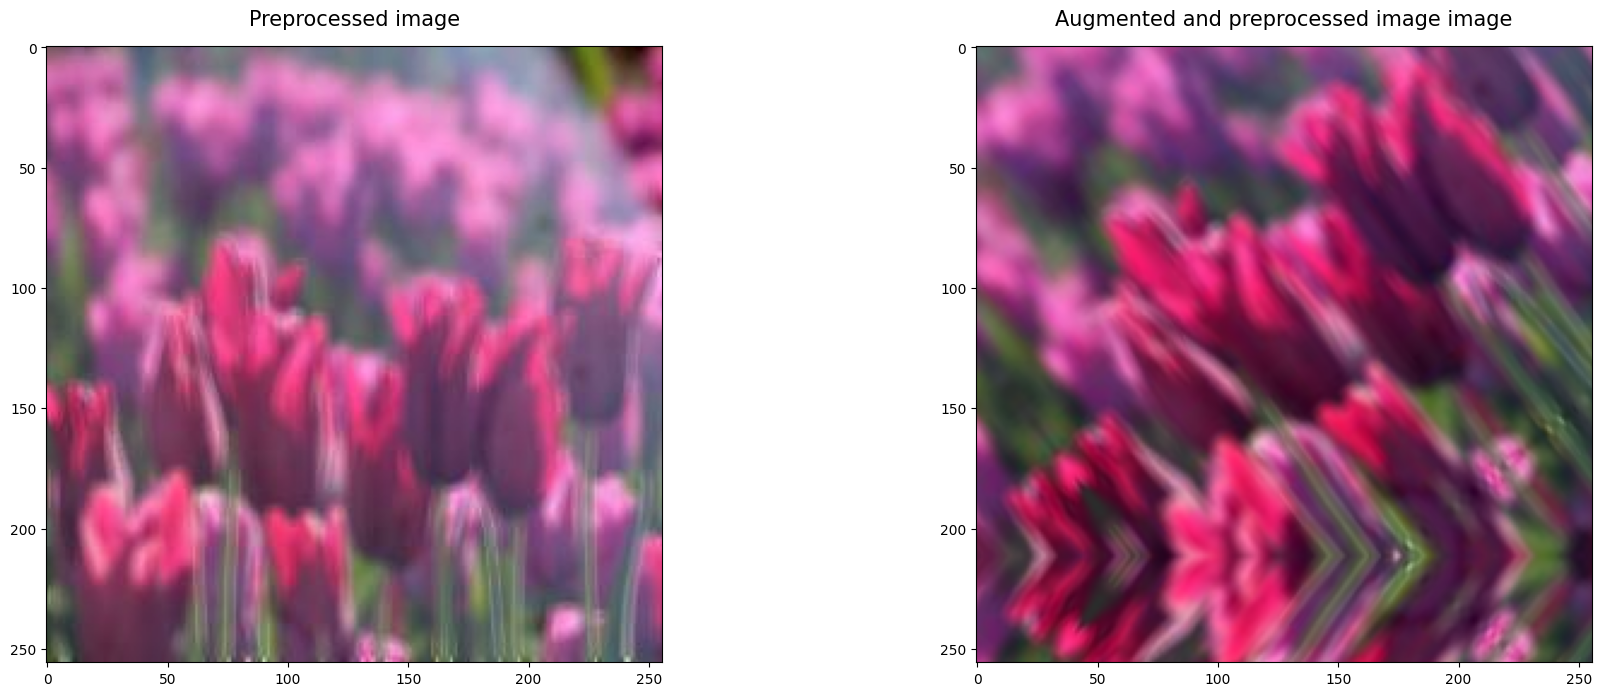

In [9]:
FONT_SIZE = 15
fig, axes = plt.subplots(1,2)

fig.set_figwidth(22)
fig.set_figheight(8)

# read image
img = list(train_ds)[0][0][0]
axes[0].imshow(tf.keras.utils.array_to_img(img))
axes[0].set_title(f"Пример размытого изображения", fontsize=FONT_SIZE, pad=15)

# augmentate image
img = augment_data(tf.expand_dims(img, axis=0))[0]
axes[1].imshow(tf.keras.utils.array_to_img(img))
axes[1].set_title(f"Пример аугментированного размытого изображения", fontsize=FONT_SIZE, pad=15)

plt.show()

### Обучение модели

#### Колбэк функции для вызова в процессе обучения

In [10]:
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

# если модель плохо учится - остановит обучение
callback_list.append(keras.callbacks.EarlyStopping(
            monitor = 'val_loss', 
            min_delta = 0.0001, 
            patience = 3,
            restore_best_weights = True
            ))

# если модель не учится - уменьшит шаг LEARNING_RATE
callback_list.append(keras.callbacks.ReduceLROnPlateau(
            monitor = 'loss', 
            factor = 0.2, 
            patience = 2, 
            verbose = 1,
            mode = 'auto', 
            min_delta = 0.001, 
            cooldown = 2, 
            min_lr = 0
            ))

#### Обучение

In [11]:
history = model.fit(train_ds,
                    batch_size = BATCH_SIZE, 
                    epochs = 30, 
                    verbose = 1, 
                    validation_data = val_ds, 
                    callbacks = callback_list)

Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 82s 588ms/step - BinaryAccuracy: 0.5110 - MeanSquaredError: 0.2603 - PR_AUC: 0.5186 - Precision: 0.5048 - ROC_AUC: 0.5122 - Recall: 0.5089 - loss: 0.7189 - val_BinaryAccuracy: 0.5014 - val_MeanSquaredError: 0.2471 - val_PR_AUC: 0.8376 - val_Precision: 0.5007 - val_ROC_AUC: 0.8075 - val_Recall: 0.9986 - val_loss: 0.6821 - learning_rate: 0.0100
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 80s 580ms/step - BinaryAccuracy: 0.6406 - MeanSquaredError: 0.2282 - PR_AUC: 0.6909 - Precision: 0.6376 - ROC_AUC: 0.6903 - Recall: 0.6589 - loss: 0.6476 - val_BinaryAccuracy: 0.5850 - val_MeanSquaredError: 0.2297 - val_PR_AUC: 0.9438 - val_Precision: 1.0000 - val_ROC_AUC: 0.9277 - val_Recall: 0.1701 - val_loss: 0.6502 - learning_rate: 0.0100
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 80s 582ms/step - BinaryAccuracy: 0.6651 - MeanSquaredError: 0.2155 - PR_AUC: 0.7273 - Precision: 0.7203 - ROC_AUC: 0.7156 - Recall: 0.5443 - loss: 0.6208 - val_BinaryAccuracy: 0.8524 - val_M

In [12]:
# итоговый размер модели
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess_part (Sequential)    │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augment_part (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 226,899 (886.33 KB)

 Trainable params: 226,897 (886.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None


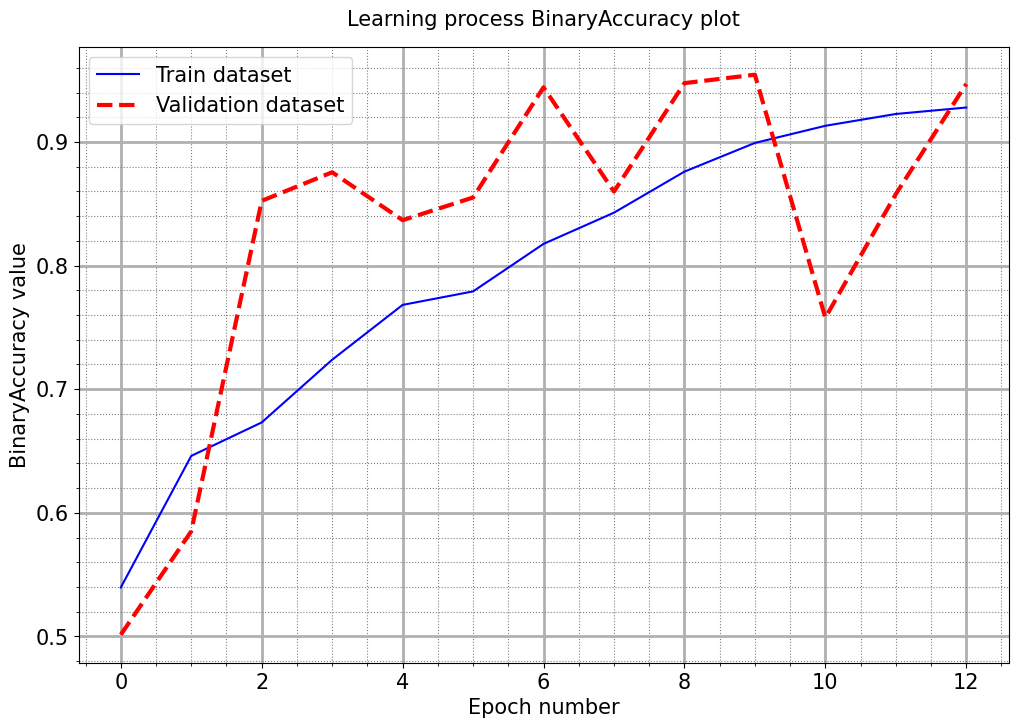

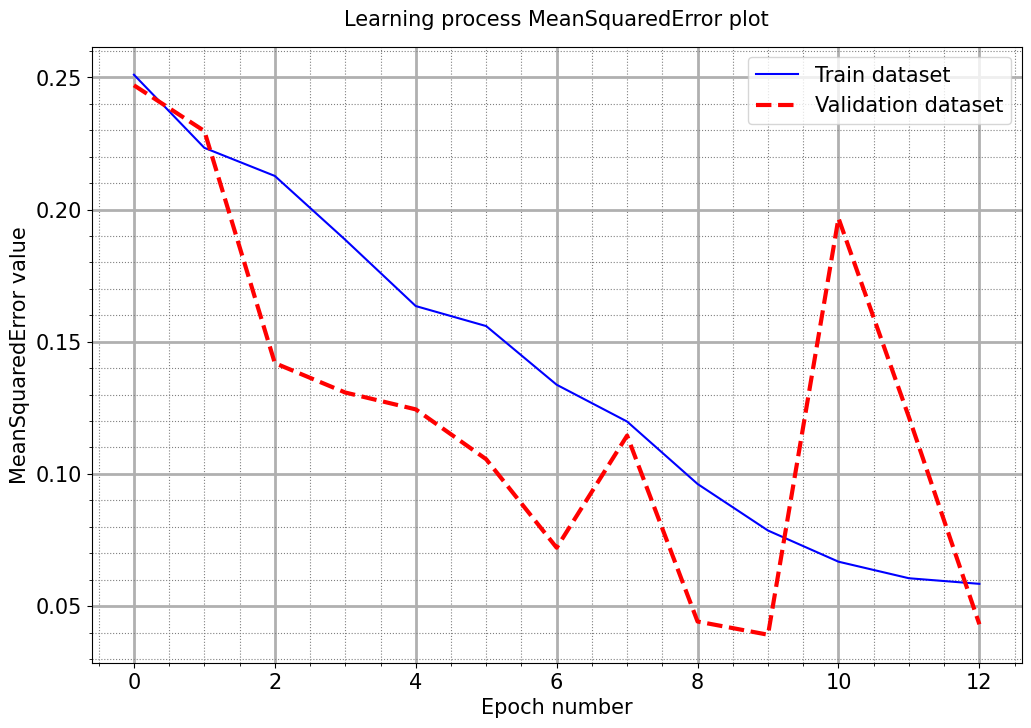

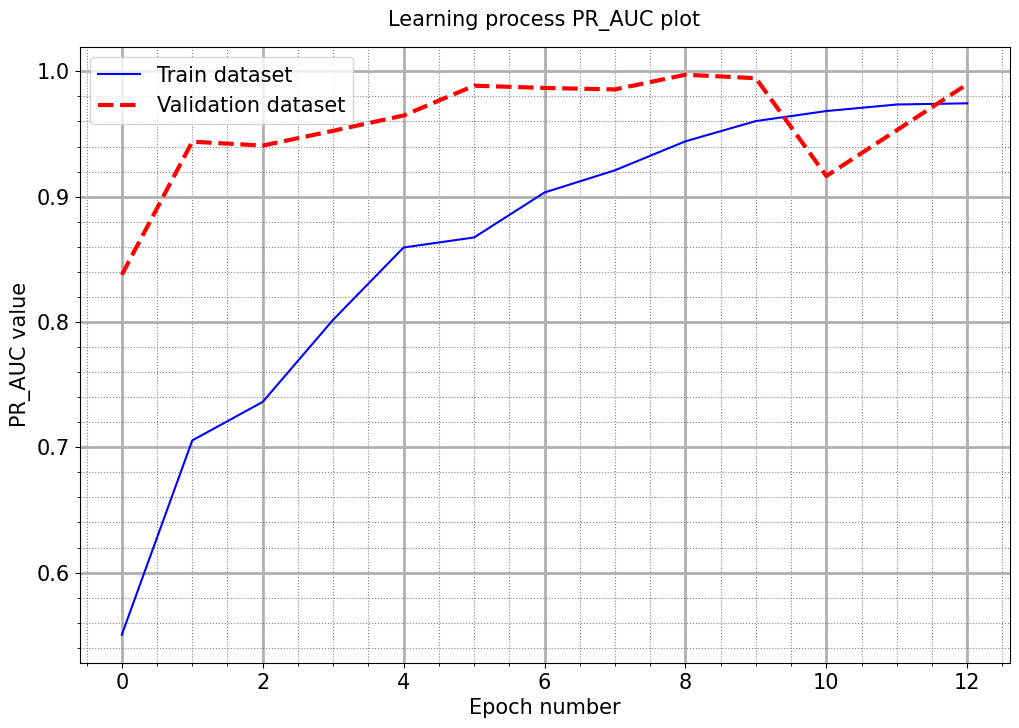

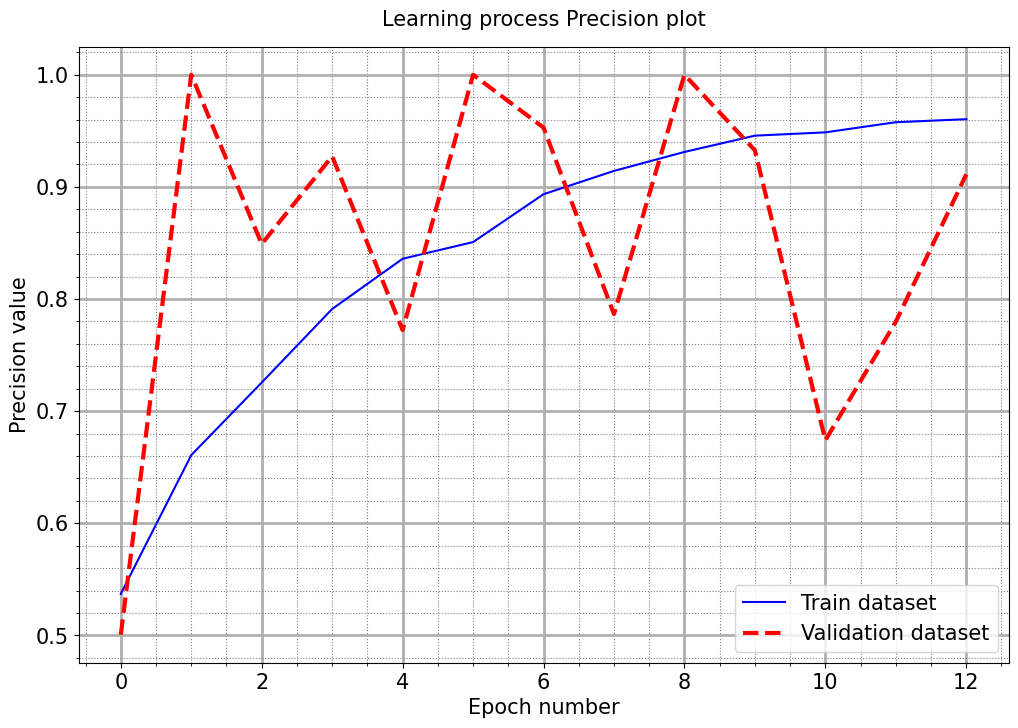

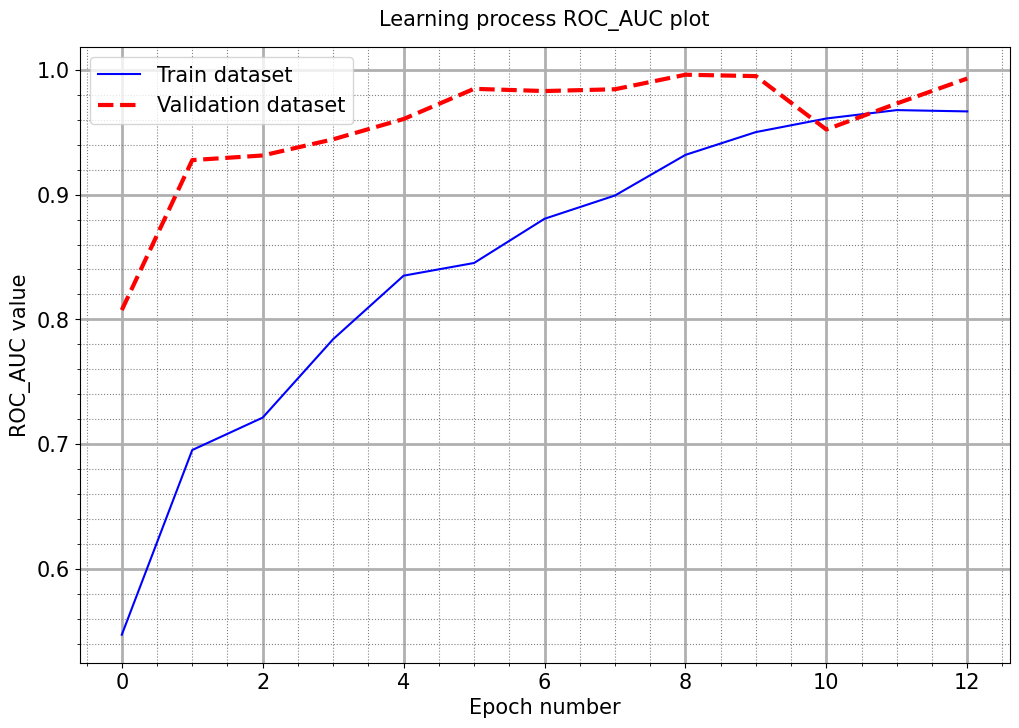

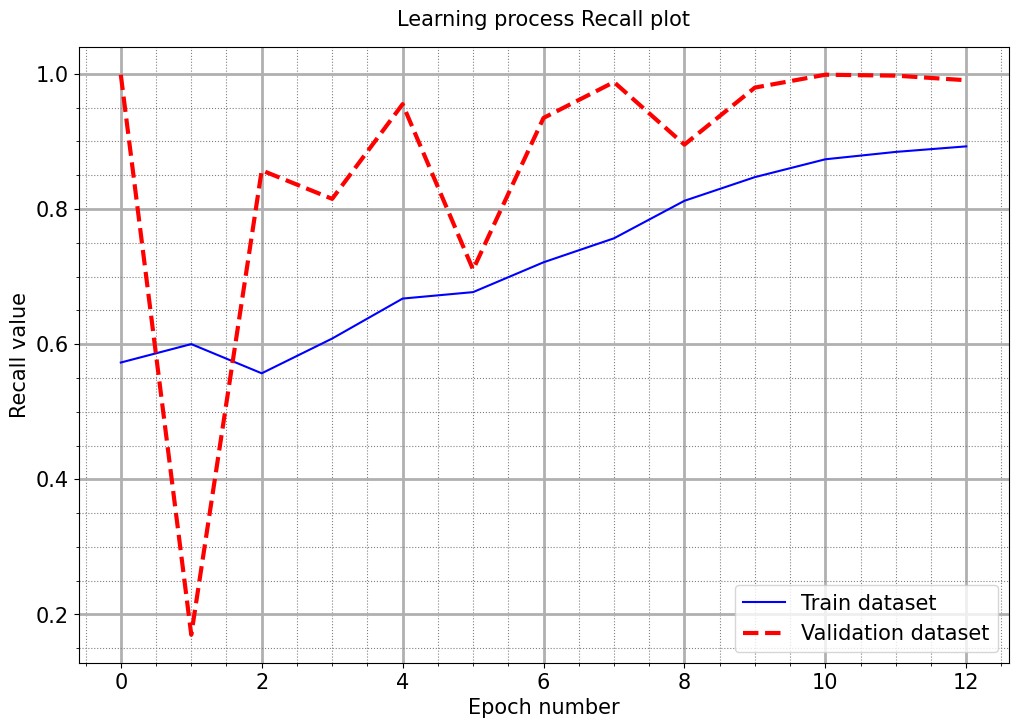

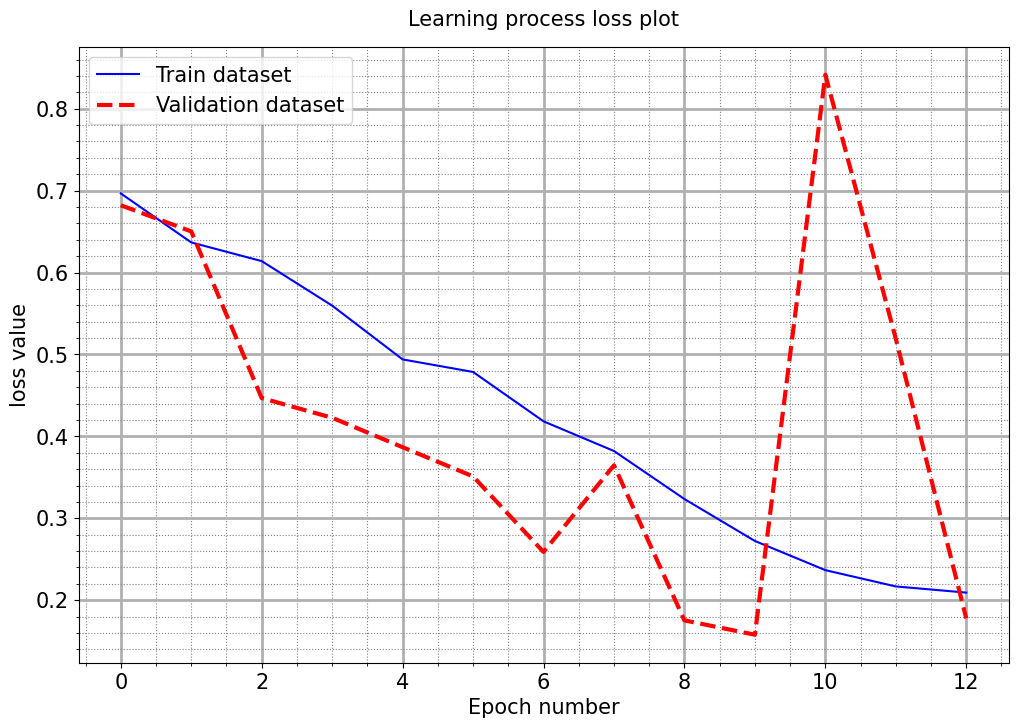

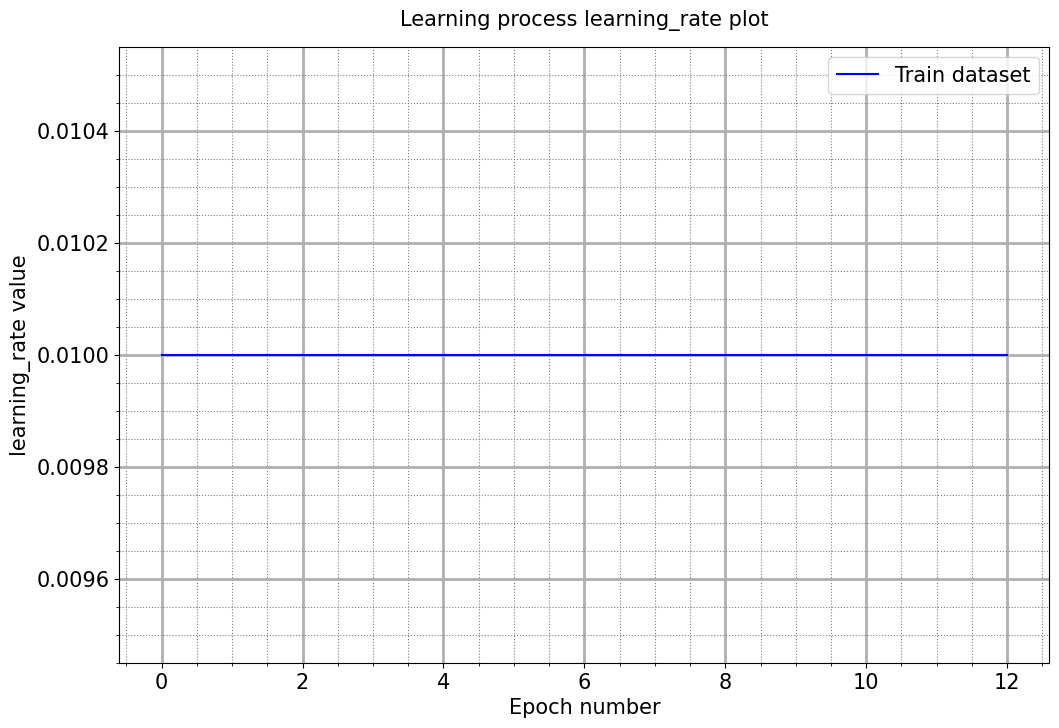

In [17]:
FONT_SIZE = 15
for key in [k for k in history.history.keys() if not k.startswith('val')]:
    fig, ax = plt.subplots()

    fig.set_figwidth(12)
    fig.set_figheight(8)
    
    plt.plot(history.history[key], 
             label='Train dataset',  linewidth=1.5, color='blue')
    if key != 'learning_rate':
        plt.plot(history.history[f'val_{key}'], linestyle = '--', 
             label='Validation dataset',  linewidth=3, color='red')
    
    ax.set_xlabel('Epoch number', fontsize=FONT_SIZE)
    ax.set_ylabel(f'{key} value', fontsize=FONT_SIZE)
    ax.set_title(f"Learning process {key} plot", fontsize=FONT_SIZE, pad=15)
    
    ax.patch.set_alpha(0)
    
    #  Устанавливаем форматирование делений:
    ax.tick_params(axis='both', which='both', labelsize = FONT_SIZE)
    
    # Вывод и настройка сетки
    ax.minorticks_on()
    ax.grid(which='major', linewidth=2)
    ax.grid(which='minor', color = 'gray', linestyle = ':')
    
    ax.legend(fontsize = FONT_SIZE, facecolor = "white")
    
    plt.show()

In [14]:
# тестирование модели и итоговые значения метрик на всех выборках
train_res = model.evaluate(train_ds, batch_size = BATCH_SIZE, verbose=0, return_dict=True)
val_res = model.evaluate(val_ds, batch_size = BATCH_SIZE, verbose=0, return_dict=True)
test_res = model.evaluate(test_ds, batch_size = BATCH_SIZE, verbose=0, return_dict=True)

In [15]:
print('|'*8,'train','|'*8)#,'\n',train_res,'\n')
print(*[(key,value) for (key,value) in train_res.items()],sep='\n')
print()
print('|'*8,'val','|'*8)#,'\n',train_res,'\n')
print(*[(key,value) for (key,value) in val_res.items()],sep='\n')
print()
print('|'*8,'test','|'*8)#,'\n',train_res,'\n')
print(*[(key,value) for (key,value) in test_res.items()],sep='\n')
print()

|||||||| train ||||||||
('BinaryAccuracy', 0.9517743587493896)
('MeanSquaredError', 0.04007343575358391)
('PR_AUC', 0.993996798992157)
('Precision', 0.9298701286315918)
('ROC_AUC', 0.9933580160140991)
('Recall', 0.9772520661354065)
('loss', 0.15906184911727905)

|||||||| val ||||||||
('BinaryAccuracy', 0.9544217586517334)
('MeanSquaredError', 0.039160601794719696)
('PR_AUC', 0.9945244193077087)
('Precision', 0.9326424598693848)
('ROC_AUC', 0.9949474930763245)
('Recall', 0.9795918464660645)
('loss', 0.1579400897026062)

|||||||| test ||||||||
('BinaryAccuracy', 0.9646739363670349)
('MeanSquaredError', 0.0346488393843174)
('PR_AUC', 0.9932786226272583)
('Precision', 0.9464752078056335)
('ROC_AUC', 0.9940530061721802)
('Recall', 0.9850543737411499)
('loss', 0.15009528398513794)



In [16]:
# сохранения модели по желанию
#model.save(f'model.keras')